In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from utils.loader import DataLoader
import matplotlib.pyplot as plt

In [3]:
batch_size = 32

In [4]:
loader = DataLoader(batch_size)
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

In [5]:
img_height, img_width, channels = list(img_ds.take(1))[0].shape[-3:]

Plot some examples (Ignore if training)

In [6]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()

In [7]:
def fix_bbox(bbox):
    temp = np.zeros_like(bbox)
    temp[0], temp[1] = bbox[1], bbox[0]
    temp[2], temp[3] = bbox[3], bbox[2]
    return temp

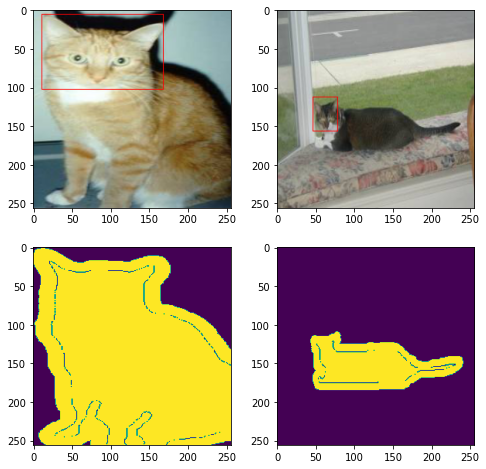

In [11]:
# View some examples
display_list = next(examples)
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

Build our MTL

In [21]:
#Augment training data to reduce overfitting by creating a pre-proccessing layer that only activates in training

data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), #random hor flip
        tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"), # random ver flip
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.5), #random rotation up to 180deg
        # tf.layers.experimental.preprocessing.RandomZoom((0,-.75)), #up to 75% zoom
    ]
)

In [27]:
def insert_intermediate_layer_in_keras(model, layer_id, new_layer):
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        x = layers[i](x)

    new_model = Model(input=layers[0].input, output=x)
    return new_model

In [15]:
# Build base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, input_shape=[img_height, img_width, 3], weights='imagenet'
)

In [29]:
# Picked each final decoding layer in the EffNet architecture
layer_names = [
    'block2a_expand_activation',
    'block3a_expand_activation',
    'block4a_expand_activation',
    'block6a_expand_activation',
    'block7a_project_conv'
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name='Encoder')
encoder.trainable = False

In [30]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [14]:
def upsample_block(filters, size):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())

  return result

In [34]:
# Build the up-sampler
inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])

# Downsampling through the model
skips = encoder(inputs)
x = skips[-1]
inter = skips[-1] # Save for output to binary classifier
skips = reversed(skips[:-1])

up_stack = [
    upsample_block(512, 3),
    upsample_block(256, 3),
    upsample_block(128, 3),
    upsample_block(64, 3), 
]

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

# Our multiple outputs
seg_out = tf.keras.layers.Conv2DTranspose(
    filters=3, kernel_size=3, strides=2,
    padding='same', name='segnet_out')(x)
bin_class_out = tf.keras.layers.GlobalAveragePooling2D(name='bin_class_pooling')(inter)
bin_class_out = keras.layers.Dense(2, activation='softmax', name='bin_class_out')(bin_class_out)

model = tf.keras.Model(inputs=inputs, outputs=[seg_out, bin_class_out])


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Functional)           [(None, 128, 128, 9  3633571     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 240                                           

Test out model

In [13]:
seg_pred, bin_pred = model.predict(display_list[0][tf.newaxis,...])

NameError: name 'display_list' is not defined

In [ ]:
bin_pred

array([[0.25048855, 0.7495115 ]], dtype=float32)

In [ ]:
seg_max = tf.argmax(seg_pred, axis=-1)
seg_max = seg_max[..., tf.newaxis][0]

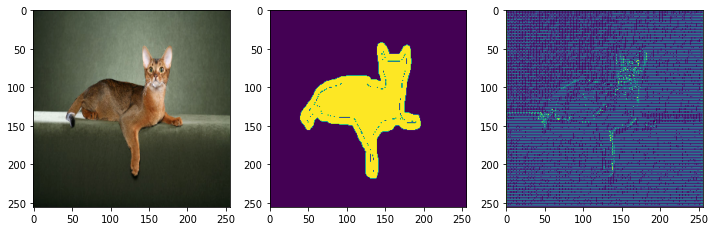

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
ax1.imshow(tf.keras.utils.array_to_img(tf.squeeze(display_list[0])))
ax2.imshow((display_list[1]))
ax3.imshow(seg_max)

Train model

In [1]:
# Can use this but use generator img fcn instead
train_ds = tf.data.Dataset.zip(((img_ds), (masks_ds, label_ds))).as_numpy_iterator()

NameError: name 'tf' is not defined

In [35]:
#keras.optimizers.Adam(4.3e-5) Errors here?
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics=['accuracy'])

In [36]:
def generator_img():
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        
        yield X, [Y1, Y2]

In [37]:
model.fit(generator_img(),epochs=10, steps_per_epoch=2000//16)

Epoch 1/10


C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


ResourceExhaustedError:  OOM when allocating tensor with shape[32,160,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/concatenate_3/concat
 (defined at C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:3224)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_16280]

Errors may have originated from an input operation.
Input Source operations connected to node model/concatenate_3/concat:
In[0] model/sequential_3/re_lu_3/Relu (defined at C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:4867)	
In[1] model/Encoder/block2a_expand_activation/IdentityN (defined at C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\activations.py:270)	
In[2] model/concatenate_3/concat/axis:

Operation defined at: (most recent call last)
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Temp/ipykernel_29436/1475082460.py", line 1, in <module>
>>>     model.fit(generator_img(),epochs=10, steps_per_epoch=2000//16)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\merge.py", line 183, in call
>>>     return self._merge_function(inputs)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\merge.py", line 528, in _merge_function
>>>     return backend.concatenate(inputs, axis=self.axis)
>>> 
>>>   File "C:\Users\mazab\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 3224, in concatenate
>>>     return tf.concat([to_dense(x) for x in tensors], axis)
>>> 